In [3]:
import sys
from pathlib import Path
from data_utils import expand_by_genre, map_genre_ids_to_strings, drop_nan_in_column, keep_top_n_genres, \
    load_final_data_with_embeddings

BASE_DIR = Path.cwd().parent.parent
SRC_DIR = BASE_DIR / 'src'
sys.path.insert(0, str(SRC_DIR))
DATA_DIR = str(BASE_DIR / "data")

GENRE_MAP_JSON_PATH = str(SRC_DIR / "cluster_to_genre_mapping_01122025.json")

RANDOM_SEED = 42
START_YEAR = 1960
TOP_X_GENRES = 5
BIN_SIZE = 10
TOP_K_GENRES = 5
MAX_MOVIES_PER_YEAR = 1000


df = load_final_data_with_embeddings(
    csv_path=f"{DATA_DIR}/final_dataset.csv",
    data_dir=DATA_DIR
)
print(df.shape)

# Drop if genre is nan
df = drop_nan_in_column(df=df, column_name="new_genre")
print(df.shape)

# Expand the movies: if it has 2 genres then repeat it 2 times one per each genre
df = expand_by_genre(df)
print(df.shape)

# Map so instead of Genre identifiers we have the genre name
df = map_genre_ids_to_strings(df, GENRE_MAP_JSON_PATH)
print(df.shape)

# Keep top k genres because 20 genre plots are ugly
df = keep_top_n_genres(df, TOP_K_GENRES)
print(df.shape)

(92374, 39)
(79984, 39)
(122968, 39)
(122968, 39)
(84053, 40)


In [2]:
print(df["new_genre"].tail(10))

92348    documentary experimental and film history
92350                           crime and thriller
92350                                        drama
92351    documentary experimental and film history
92364        documentary animation and educational
92365                                        drama
92366                                       comedy
92370                            fantasy and scifi
92372                                       comedy
92372                            fantasy and scifi
Name: new_genre, dtype: object


# Genre drift Metrics: Velocity, Acceleration and Cumulative Change

We group movies by year and genre, to analyze how each group changes it's average embedding cosine distance.

For each genre, we calculate how much the genre has changed each year compared to the previous year (drift distance) and the cumulative change over time (cumulative change).

We also calculate the acceleration, the change of the velocity over the year.




genre action western and international: 1930: 473
genre comedy: 1930: 1000
genre crime and thriller: 1930: 781
genre drama: 1930: 1000
genre romance: 1930: 757
genre action western and international: 1940: 453
genre comedy: 1940: 1000
genre crime and thriller: 1940: 772
genre drama: 1940: 1000
genre romance: 1940: 550
genre action western and international: 1950: 871
genre comedy: 1950: 1000
genre crime and thriller: 1950: 835
genre drama: 1950: 1000
genre romance: 1950: 542
genre action western and international: 1960: 746
genre comedy: 1960: 1000
genre crime and thriller: 1960: 745
genre drama: 1960: 1000
genre romance: 1960: 424
genre action western and international: 1970: 1000
genre comedy: 1970: 1000
genre crime and thriller: 1970: 922
genre drama: 1970: 1000
genre romance: 1970: 335
genre action western and international: 1980: 1000
genre comedy: 1980: 1000
genre crime and thriller: 1980: 919
genre drama: 1980: 1000
genre romance: 1980: 634
genre action western and international

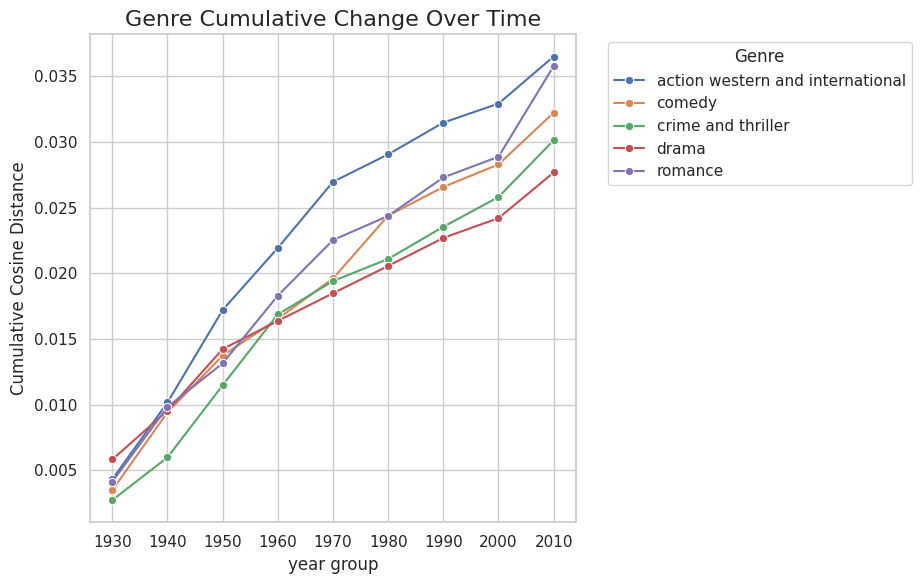

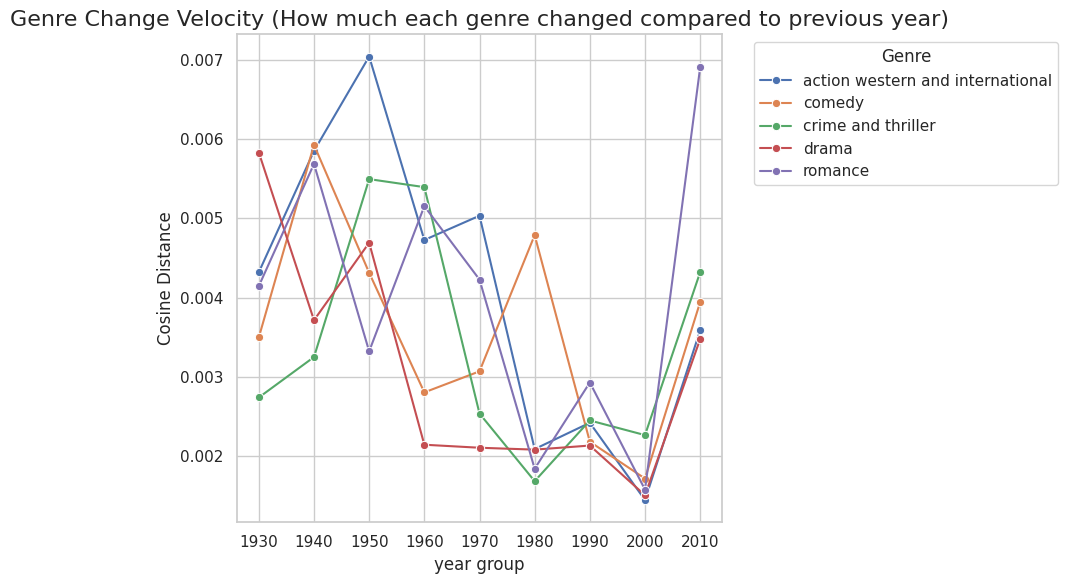

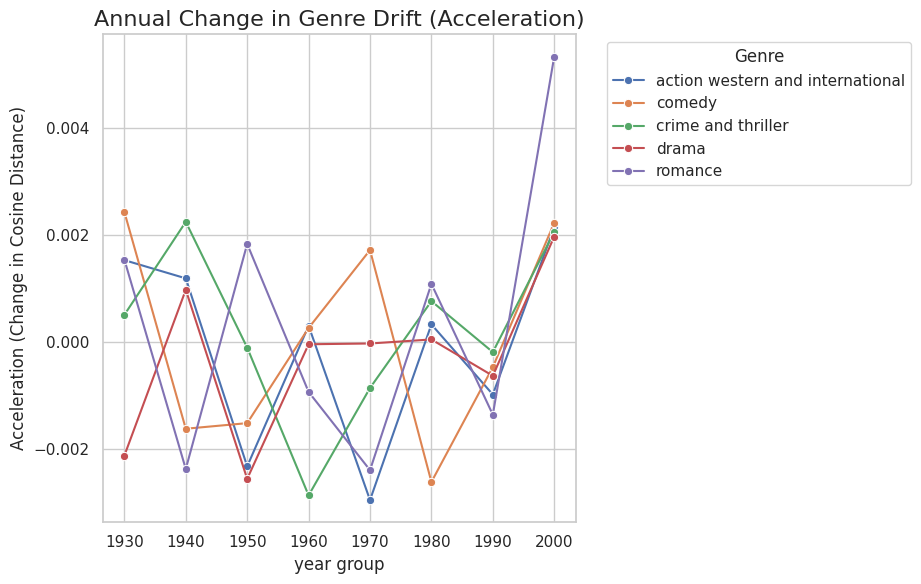

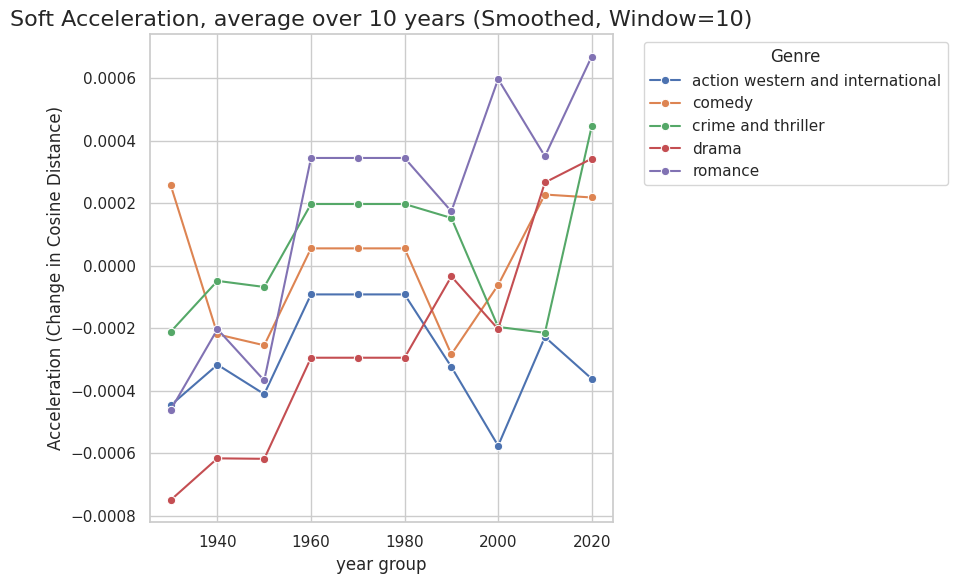

In [4]:
from analysis.stats_data import plot_genre_drift
from analysis.genre_drift_utils import calculate_drift_metrics

drift_df = calculate_drift_metrics(df, n_years_per_group=BIN_SIZE, max_movies_per_group=MAX_MOVIES_PER_YEAR)

print("\nDrift DataFrame Info:")
print(drift_df.info())

plot_genre_drift(
    df=drift_df,
    y_column='drift_velocity_cum',
    title='Genre Cumulative Change Over Time',
    y_label='Cumulative Cosine Distance'
)

plot_genre_drift(
    df=drift_df,
    y_column='drift_velocity',
    title='Genre Change Velocity (How much each genre changed compared to previous year)',
    y_label='Cosine Distance'
)

plot_genre_drift(
    df=drift_df,
    y_column='drift_acceleration',
    title='Annual Change in Genre Drift (Acceleration)',
    y_label='Acceleration (Change in Cosine Distance)',
    softness_window=None
)

soft_years = 10
plot_genre_drift(
    df=drift_df,
    y_column='drift_acceleration',
    title=f'Soft Acceleration, average over {soft_years} years',
    y_label='Acceleration (Change in Cosine Distance)',
    softness_window=10
)


# Heatmaps of genre drift

For each genre, we group the data into time bins (e.g., 5 or 10 years) and calculate the mean embedding vector for each bin. The drift distance (velocity) is then calculated as the Cosine Distance between the mean embedding vector of one time bin and the next. This distance measures how much the overall genre meaning has shifted or evolved between the two periods.

We plot heatmaps and to visualize the relationships between different time periods within each genre. Y axis is each embedding dimension, X axis is change between two time intervals. The intensity of the color represents the magnitude of the drift (Cosine Distance), showing if the genre is rapidly changing (high distance) or stable (low distance) over time. The color of the color represents the direction of the change, orange if positive, blue if negative. If two time consecutive time periods have the same color, it means that the genre is evolving in the same direction. If it has different colors, the direction has changed between those two time periods.

There are two plots per genre. The first one has the Y axis ordered according to the vector embeddings, the second one is clustered by directions which evolve in similar directions (positive / negative) so it can be interpreted easier.


In [ ]:
for genre in df_movies['new_genre'].unique():
    plot_data, bin_size = prepare_heatmap_data(drift_df, target_genre=genre, bin_size=10)

    plot_standard_heatmap(plot_data, target_genre=genre, bin_size=bin_size)
    plot_clustermap(plot_data, target_genre=genre, bin_size=bin_size)


# Inter-genre distance analysis

First plot visualizes the semantic separation between every pair of genres over time. For a single target genre (e.g., Comedy), it calculates the Cosine Distance between its average embedding vector and the vector of every other genre (e.g., Action, Drama) for each year or time bin. This results in many lines on the chart, where each line shows the changing distance between the target genre and one other genre. The plot shows if the meaning of two specific genres is getting closer (converging) or further apart (diverging) over time.

Second plot visualizes how unique or isolated each genre is compared to the rest of the film landscape over time. For a single target genre (e.g., Comedy), it first computes the average embedding vector of all the other genres combined. It then calculates the Cosine Distance between the target genre's vector and this single "mean of all others" vector for each time period. The plot shows one line per genre: if the line trends down, the genre is becoming more typical of the overall average; if it trends up, the genre is becoming more distinct.


In [ ]:
target_genres = drift_df['new_genre'].unique()
convergence_df = calculate_genre_convergence(drift_df, bin_size=5, target_genres=target_genres)

print(convergence_df.head(10))

horror_action_trend = convergence_df[(convergence_df['Genre_A'] == 'Horror') & (convergence_df['Genre_B'] == 'Action')]
print(horror_action_trend)

In [ ]:
plot_pairwise_convergence(convergence_df, target_genres)
plot_mean_convergence(convergence_df, target_genres)